In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import spiral_data
nnfs.init()

In [40]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_L1=0, bias_regularizer_L1=0,
                 weight_regularizer_L2=0, bias_regularizer_L2=0):
        # Initialize weights and biases
        self.weights = 0.1 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength
        self.weight_regularizer_L1 = weight_regularizer_L1
        self.weight_regularizer_L2 = weight_regularizer_L2
        
        self.bias_regularizer_L1 = bias_regularizer_L1
        self.bias_regularizer_L2 = bias_regularizer_L2

    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        self.inputs = inputs

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        if self.weight_regularizer_L1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_L1 * dL1
            
        if self.weight_regularizer_L2 > 0:
            self.dweights += 2 * self.weight_regularizer_L2 * self.weights
            
        if self.bias_regularizer_L1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_L1 * dL1
            
        if self.bias_regularizer_L2 > 0:
            self.dbiases += 2 * self.bias_regularizer_L2 * self.biases
        
        
        self.dinputs = np.dot(dvalues, self.weights.T)
        

class Layer_Dropout:
    def __init__(self, rate):
        self.rate = 1 - rate
        
    def forward(self, inputs):
        self.inputs = inputs
        
        self.binary_mask = np.random.binomial(1, self.rate, \
                                              size=inputs.shape) - self.rate
        self.output = inputs * self.binary_mask
        
    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask

In [3]:
class Activation_ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        self.inputs = inputs

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0


class Activation_Softmax:
    def forward(self, inputs):
        self.inputs = inputs
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)

        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [4]:
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss
    
    def regularization_loss(self, layer):
        regularization_loss = 0
        
        if layer.weight_regularizer_L1 > 0:
            regularization_loss += layer.weight_regularizer_L1 * \
                                    np.sum(np.abs(layer.weights))
            
        if layer.weight_regularizer_L2 > 0:
            regularization_loss += layer.weight_regularizer_L2 * \
                                    np.sum(np.abs(layer.weights ** 2))
        
        if layer.bias_regularizer_L1 > 0:
            regularization_loss += layer.bias_regularizer_L1 * \
                                    np.sum(np.abs(layer.biases))
            
        if layer.bias_regularizer_L2 > 0:
            regularization_loss += layer.bias_regularizer_L2 * \
                                    np.sum(np.abs(layer.biases ** 2))
        
        return regularization_loss
        


class Loss_CategoricalCrossEntropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # change all values less than 1e-7 to 1e-7 and all the values greater than 1- 1e-7 to 1- 1e-7
        
        if len(y_true.shape) == 1:     # it means our target values list is not one-hot encoded
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:  # target values list is one-hot encoded
            correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)

        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])

        if(len(y_true.shape) == 1):
            y_true = np.eye(labels)[y_true]

        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples

In [5]:
class Activation_Softmax_Loss_CategoricalCrossentropy():
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossEntropy()

    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output

        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples

In [6]:
class Optimizer_SGD:
    def __init__(self, learning_rate=1.0, decay=0., momentum= 0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1 + self.decay * self.iterations))
    
    def update_params(self, layer):
        if self.momentum:
            if not hasattr(layer, "weight_momentums"):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            weight_updates = self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            
            bias_updates = self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = - self.current_learning_rate - layer.dbiases
            
        layer.weights += weight_updates
        layer.biases += bias_updates
        
    def post_update_params(self):
        self.iterations += 1
        
        

class Optimizer_AdaGrad:
    def __init__(self, learning_rate=1.0, decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.epsilon = epsilon
        self.iterations = 0
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1 + self.decay * self.iterations))
    
    def update_params(self, layer):
        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_cache += layer.dweights ** 2
        layer.bias_cache += layer.dbiases ** 2
        
        layer.weights += -self.current_learning_rate * layer.dweights / \
                            (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / \
                            (np.sqrt(layer.bias_cache) + self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1
        
        

class Optimizer_RMSProp:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.epsilon = epsilon
        self.rho = rho
        self.iterations = 0
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1 + self.decay * self.iterations))
    
    def update_params(self, layer):
        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_cache += self.rho * layer.weight_cache + \
            (1 - self.rho) * layer.dweights ** 2
        layer.bias_cache += self.rho * layer.bias_cache + \
            (1 - self.rho) * layer.dbiases ** 2
        
        layer.weights += -self.current_learning_rate * layer.dweights / \
                            (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / \
                            (np.sqrt(layer.bias_cache) + self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1
        
        

class Optimizer_Adam:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum  with current gradients
        layer.weight_momentums = self.beta_1 * \
                                 layer.weight_momentums + \
                                 (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
                               layer.bias_momentums + \
                               (1 - self.beta_1) * layer.dbiases
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
            (1 - self.beta_2) * layer.dweights**2

        layer.bias_cache = self.beta_2 * layer.bias_cache + \
            (1 - self.beta_2) * layer.dbiases**2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) +
                             self.epsilon)
        layer.biases += -self.current_learning_rate * \
                         bias_momentums_corrected / \
                         (np.sqrt(bias_cache_corrected) +
                             self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

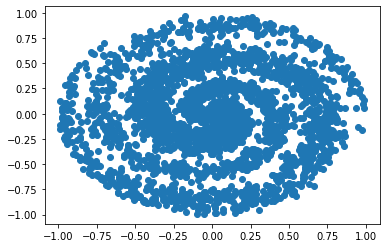

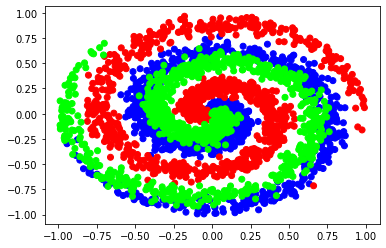

In [36]:
X, y = spiral_data(1000, 3)
plt.scatter(X[:,0], X[:,1])
plt.show()

plt.scatter(X[:,0], X[:,1], c=y, cmap="brg")
plt.show()

In [37]:
#initialize network
layer1 = Layer_Dense(2, 512,          # 2 because our spiral data has 2 feautures (x and y coordinates)
                     weight_regularizer_L2=5e-4,
                     bias_regularizer_L2=5e-4)
activation1 = Activation_ReLU()
layer2 = Layer_Dense(512, 3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = Optimizer_Adam(learning_rate=0.02, decay=1e-5)

for epoch in range(10001):
    #forward pass
    layer1.forward(X)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    data_loss = loss_activation.forward(layer2.output, y)
    regularization_loss = loss_activation.loss.regularization_loss(layer1) + \
                          loss_activation.loss.regularization_loss(layer2)
    loss = data_loss + regularization_loss

    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)
    
    if not epoch % 1000:
        print(f"epoch: {epoch}, "+
              f"Accuracy: {accuracy:.3f},"+
              f"Loss: {loss:.3f}")
    
    #backpropagation
    loss_activation.backward(loss_activation.output, y)
    layer2.backward(loss_activation.dinputs)
    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)

    #update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)
    optimizer.post_update_params()


epoch: 0, Accuracy: 0.282,Loss: 1.114
epoch: 1000, Accuracy: 0.909,Loss: 0.350
epoch: 2000, Accuracy: 0.913,Loss: 0.331
epoch: 3000, Accuracy: 0.913,Loss: 0.296
epoch: 4000, Accuracy: 0.921,Loss: 0.271
epoch: 5000, Accuracy: 0.919,Loss: 0.276
epoch: 6000, Accuracy: 0.926,Loss: 0.259
epoch: 7000, Accuracy: 0.923,Loss: 0.253
epoch: 8000, Accuracy: 0.927,Loss: 0.258
epoch: 9000, Accuracy: 0.929,Loss: 0.250
epoch: 10000, Accuracy: 0.926,Loss: 0.245


In [39]:
X_test, y_test = spiral_data(samples=1000, classes=3)

layer1.forward(X_test)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
loss = loss_activation.forward(layer2.output, y_test)

predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == y_test)

print(f"validation, acc: {accuracy: .3f}, loss:{loss:.3f}")

validation, acc:  0.903, loss:0.278
